In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

C:\Users\zalde\AppData\Local\Temp\ipykernel_11520\3267213166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('testset.csv')

In [3]:
df.tail()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
100985,20170424-06:00,Haze,17.0,0,0,NaN,25.0,NaN,1005.0,0,0,34.0,0,0,4.0,320.0,NW,NaN,NaN,11.1
100986,20170424-09:00,Haze,14.0,0,0,NaN,16.0,NaN,1003.0,0,0,38.0,0,0,4.0,320.0,NW,NaN,NaN,22.2
100987,20170424-12:00,Haze,12.0,0,0,NaN,14.0,NaN,1002.0,0,0,36.0,0,0,4.0,270.0,West,NaN,NaN,18.5
100988,20170424-15:00,Haze,15.0,0,0,NaN,27.0,NaN,1004.0,0,0,32.0,0,0,2.0,320.0,NW,NaN,NaN,3.7
100989,20170424-18:00,Haze,15.0,0,0,NaN,30.0,NaN,1005.0,0,0,30.0,0,0,2.0,320.0,NW,NaN,NaN,3.7


In [4]:
df.isnull().sum()

datetime_utc         0
 _conds             72
 _dewptm           621
 _fog                0
 _hail               0
 _heatindexm     71835
 _hum              757
 _precipm       100990
 _pressurem        232
 _rain               0
 _snow               0
 _tempm            673
 _thunder            0
 _tornado            0
 _vism            4428
 _wdird          14755
 _wdire          14755
 _wgustm         99918
 _windchillm    100411
 _wspdm           2358
dtype: int64

In [5]:
df = df[["datetime_utc"," _tempm"]]

In [6]:
df.columns =["date", 'temp']

In [7]:
df.isnull().sum()

date      0
temp    673
dtype: int64

In [8]:
df.dropna(inplace = True)

In [9]:
df["date"] = pd.to_datetime(df["date"])

In [10]:
df = df.set_index('date')

In [27]:
temp_max = df['temp'].max()
temp_min = df['temp'].min()

In [28]:
scaler = MinMaxScaler(feature_range = (0, 1))
data = scaler.fit_transform(df)
print(data)
temp_max_normalized = scaler.transform([[temp_max]])[0][0]
temp_min_normalized = scaler.transform([[temp_min]])[0][0]

[[0.3258427 ]
 [0.30337079]
 [0.25842697]
 ...
 [0.39325843]
 [0.34831461]
 [0.3258427 ]]


c:\Users\zalde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\zalde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


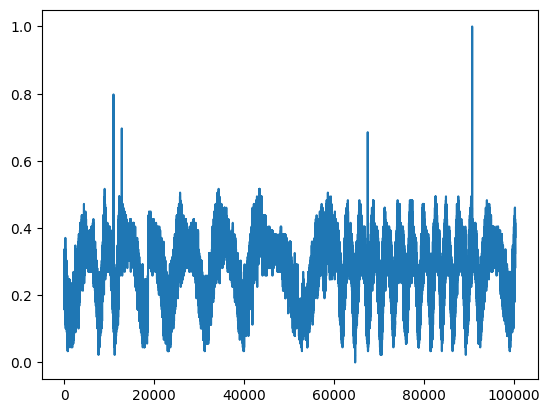

In [13]:
plt.plot(data)

In [14]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)


In [15]:
def dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [16]:
X_train, y_train = dataset(train_data, 100)
X_val, y_val = dataset(val_data, 100)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(100, 1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [18]:
early_stop = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto'
)

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
)


In [20]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10


627/627 [==============================] - 262s 405ms/step - loss: 0.0264 - mae: 0.2063 - val_loss: 0.0147 - val_mae: 0.1493
Epoch 2/10
627/627 [==============================] - 209s 333ms/step - loss: 0.0104 - mae: 0.1235 - val_loss: 0.0071 - val_mae: 0.1024
Epoch 3/10
627/627 [==============================] - 242s 386ms/step - loss: 0.0061 - mae: 0.0953 - val_loss: 0.0051 - val_mae: 0.0869
Epoch 4/10
627/627 [==============================] - 274s 437ms/step - loss: 0.0050 - mae: 0.0858 - val_loss: 0.0046 - val_mae: 0.0815
Epoch 5/10
627/627 [==============================] - 277s 442ms/step - loss: 0.0047 - mae: 0.0820 - val_loss: 0.0043 - val_mae: 0.0781
Epoch 6/10
627/627 [==============================] - 271s 433ms/step - loss: 0.0045 - mae: 0.0798 - val_loss: 0.0042 - val_mae: 0.0769
Epoch 7/10
627/627 [==============================] - 241s 384ms/step - loss: 0.0044 - mae: 0.0787 - val_loss: 0.0042 - val_mae: 0.0763
Epoch 8/10
177/627 [=======>..................

KeyboardInterrupt: 

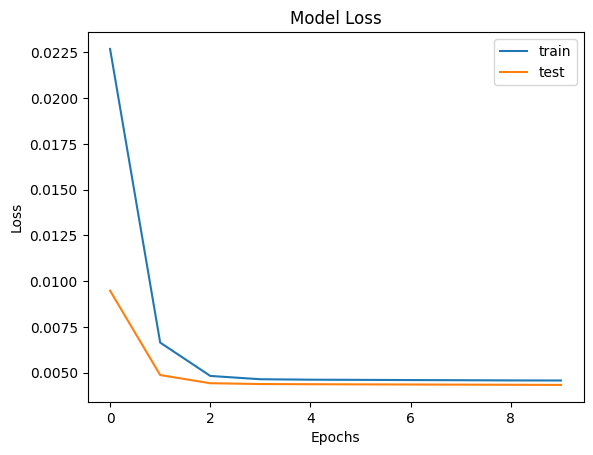

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

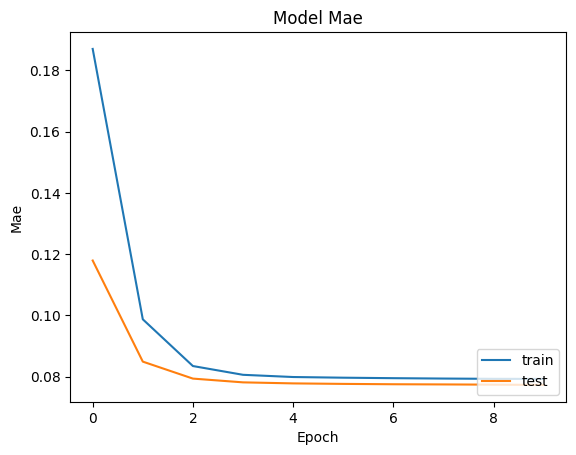

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [29]:
threshold_mae = (temp_max_normalized - temp_min_normalized) * 10 / 100
print(f'Threshold MAE: {threshold_mae:.4f}')

val_predictions = model.predict(X_val)
val_mae = np.mean(np.abs(val_predictions - y_val))

if val_mae < threshold_mae:
    print(f'MAE: {val_mae:.4f} < Threshold MAE: {threshold_mae:.4f}.')
else:
    print(f'MAE: {val_mae:.4f} > Threshold MAE: {threshold_mae:.4f}.')

Threshold MAE: 0.1000
624/624 [==============================] - 24s 38ms/step
MAE: 0.0783 < Threshold MAE: 0.1000.
